# `jupyterlite 0.1.0b4+main` vs `pyodide 0.20.0`

> This is very much a work-in-progress. See the [history below](#History) or follow along on the [draft PR](https://github.com/jupyterlite/jupyterlite/pull/274).

In [1]:
import sys, os, asyncio, pyolite, IPython
from pathlib import Path
print(len(sys.modules), "are loaded")

929 are loaded


We should now be running python 3.10

In [2]:
assert sys.version.startswith('3.10')
sys.version

'3.10.2 (main, Mar 24 2022, 16:34:43) [Clang 14.0.0 (https://github.com/llvm/llvm-project 78e87970af888bbbd5652c31f3a8'

Our "user" should have a writeable `$HOME` dir:

In [3]:
HOME = Path(os.path.expanduser("~"))
HOME

PosixPath('/home/pyodide')

In [4]:
assert str(HOME) == os.environ.get("HOME"), f"there's no place like {HOME}"
print(sorted(HOME.glob("*")))

[PosixPath('/home/pyodide/.ipython'), PosixPath('/home/pyodide/.matplotlib')]


The process launches in `/`

In [5]:
os.getcwd()

'/home/pyodide'

In [6]:
assert os.getcwd() == "/home/pyodide"

## JS

In [7]:
import pyodide, pyodide_js, js
print(len(sys.modules))

929


### FS: The Emscripten Filesystem API

We're now expecting the newly-hoisted `pyodide.FS` API, _with_ all the filesystems, e.g. `IDBFS`

In [8]:
FS = pyodide_js.FS
js.Object.keys(FS)

root,mounts,devices,streams,nextInode,nameTable,currentPath,initialized,ignorePermissions,trackingDelegate,tracking,ErrnoError,genericErrors,filesystems,syncFSRequests,lookupPath,getPath,hashName,hashAddNode,hashRemoveNode,lookupNode,createNode,destroyNode,isRoot,isMountpoint,isFile,isDir,isLink,isChrdev,isBlkdev,isFIFO,isSocket,flagModes,modeStringToFlags,flagsToPermissionString,nodePermissions,mayLookup,mayCreate,mayDelete,mayOpen,MAX_OPEN_FDS,nextfd,getStream,createStream,closeStream,chrdev_stream_ops,major,minor,makedev,registerDevice,getDevice,getMounts,syncfs,mount,unmount,lookup,mknod,create,mkdir,mkdirTree,mkdev,symlink,rename,rmdir,readdir,unlink,readlink,stat,lstat,chmod,lchmod,fchmod,chown,lchown,fchown,truncate,ftruncate,utime,open,close,isClosed,llseek,read,write,allocate,mmap,msync,munmap,ioctl,readFile,writeFile,cwd,chdir,createDefaultDirectories,createDefaultDevices,createSpecialDirectories,createStandardStreams,ensureErrnoError,staticInit,init,quit,getMode,findObject,a

In [9]:
assert FS, "this is not the API you are looking for"

#### POSIX Paths

##### Creating Directories

We can still synchronously `mkdir`:

In [10]:
FOO = Path("/tmp/foo")
FS.mkdir(str(FOO))

[object Object]

In [11]:
assert FOO.exists()
sorted(FOO.glob("*"))

[]

##### Creating Files

We can also synchronously write files:

In [12]:
BAR = FOO / "bar.txt"
FS.writeFile(str(BAR), "hello world") 

In [13]:
assert BAR.read_text() == "hello world"

#### filesystems: implementation-specific storage options

In [14]:
js.Object.keys(FS.filesystems)

MEMFS,IDBFS,NODEFS,WORKERFS,PROXYFS

##### Example: IDBFS

Of interest, as we already make use of `IndexedDB`, is the `FS.filesystems.IDBFS`, which implements bi-directional, asynchronous syncing. User code can make use of this API directly, with some caveats.

##### Creating the path

In [15]:
WORK = HOME / "work"
FS.mkdir(str(WORK))

[object Object]

##### Create the mount

In [16]:
FS.mount(FS.filesystems.IDBFS, {}, str(WORK))

[object Object]

##### Sync data _from_ the `IndexedDB` to the file system

`syncfs` expects a node-style callback, and callback arguments to old-style JavaScript functions need to be explicitly proxied.

In [17]:
async def syncfs(to_fs):
    future = asyncio.Future()
    handler =  pyodide.create_once_callable(lambda err: (
        f.set_exception(Exception(err)) if err else future.set_result(True)
    ))
    FS.syncfs(to_fs, handler)
    return await future

In [18]:
await syncfs(to_fs=True)

True

##### Do some files, update some files

In [19]:
AGENDA = WORK / "agenda.md"
agenda = AGENDA.read_text() if AGENDA.exists() else "# Agenda"

In [20]:
agenda += "\n\n## Item " + f"{len(agenda.splitlines())}" + "\n"

In [21]:
AGENDA.write_text(agenda)

82

##### Sync data _to_ the `IndexedDB` from the file system

`syncfs` expects a node-style callback.

In [22]:
await syncfs(to_fs=False)

True

Now, theoretically, when re-running this, one should see agenda get longer and longer.

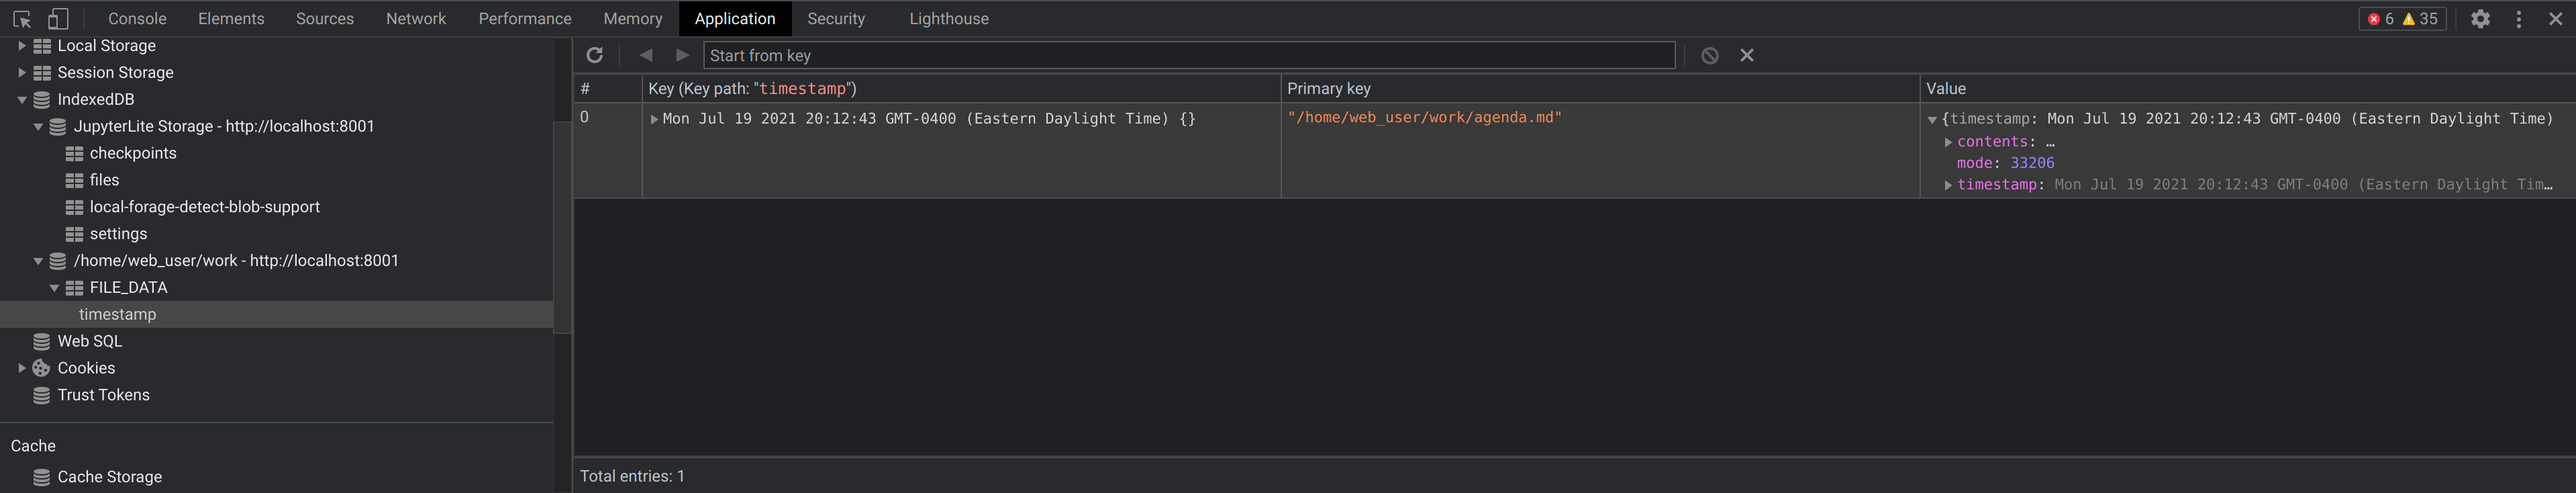

In [23]:
IPython.display.Markdown(AGENDA.read_text())

# Agenda

## Item 1


## Item 3


## Item 6


## Item 9


## Item 12


## Item 15


## History

### 2021-07-16
- [#1692](https://github.com/pyodide/pyodide/pull/1692) [`60acd00`](https://github.com/pyodide/pyodide/commit/60acd0089fdba03777e31dc05cad268271666423) merged, exposing `FS`.

### 2021-07-16
- [#1596](https://github.com/pyodide/pyodide/pull/1596) [`f13f33`](https://github.com/pyodide/pyodide/commit/f13f3340e0458bb78ff653383352b61a57cb6c17) merged, ensuring all `filesystem`s are supported

### 2021-07-18 
- `FS` available from `jsdeliver` nightly, but `Pygments.js` failed to load

### 2021-07-19 
- `FS` available from `jsdelivr`
- everything mostly works 🎉
- some proxy borrow errors if left unattended for a while, but no showstoppers for debugging and interactive authoring
  - <details><code>Uncaught (in promise) Error: This borrowed attribute proxy was automatically destroyed in the process of destroying the proxy it was borrowed from. Try using the 'copy' method.</code></details>

### 2022-03-25 
- update for `jupyterlite 0.1.0b4+main` and `pyodide 0.20.0`
- python 3.10
- updated `syncfs` example with `create_once_callable`